In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datajoint as dj
import pandas as pd
import ipyvolume as p3

# must have dj-stor1 mounted and accessible from your Docker container

dj.config['external-stack'] = {'protocol': 'file','location': '/mnt/dj-stor01/pipeline-externals'} 

# datajoint schemas

plat = dj.create_virtual_module('pipeline_platinum','pipeline_platinum')
meso = dj.create_virtual_module('pipeline_meso', 'pipeline_meso')
reso = dj.create_virtual_module('pipeline_reso', 'pipeline_reso')
tune = dj.create_virtual_module('pipeline_tune', 'pipeline_tune')
stack = dj.create_virtual_module('pipeline_stack', 'pipeline_stack')
anatomy = dj.create_virtual_module('pipeline_anatomy', 'pipeline_anatomy')

radtune = dj.create_virtual_module('pipeline_radtune','pipeline_radtune')
spattune = dj.create_virtual_module('pipeline_spattune','pipeline_spattune')

Connecting stelios@10.28.0.34:3306


# Approved platinum scans

In [2]:
plat_scans = plat.CuratedScan & 'animal_id = 17797' & 'score = 4' & 'scan_purpose = "trainable_platinum_classic"'
plat_scans

# plat = dj.create_virtual_module('pipeline_platinum','pipeline_platinum')
# plat.CuratedScan & 'animal_id = 17797 and scan_purpose LIKE "%%trainable%%"'

*animal_id    *session    *scan_idx    *scan_purpose  username     score     notes         
+-----------+ +---------+ +----------+ +------------+ +----------+ +-------+ +------------+
17797         6           4            trainable_plat Paul         4         switched to vi
17797         6           6            trainable_plat Paul         4         some squinting
17797         6           7            trainable_plat Paul         4         some squinting
17797         8           5            trainable_plat Paul         4                       
 (Total: 4)

# Approved platinum stack

In [3]:
stack_key = {'animal_id':17797,'stack_idx':19}

In [4]:
# stack info
# for description: (stack.CorrectedStack & stack_key).heading
stack.CorrectedStack & stack_key

*animal_id    *session    *stack_idx    *volume_id    z         y            x           px_depth     px_height     px_width     um_depth     um_height     um_width     surf_z    
+-----------+ +---------+ +-----------+ +-----------+ +-------+ +----------+ +---------+ +----------+ +-----------+ +----------+ +----------+ +-----------+ +----------+ +--------+
17797         9           19            1             314.0     -173.688     -236.91     335          661           706          670.0        1322.0        1412.0       -21.0     
 (Total: 1)

In [5]:
# slices of the stack
stack.CorrectedStack.Slice & stack_key

*animal_id    *session    *stack_idx    *volume_id    *channel    *islice    slice     
+-----------+ +---------+ +-----------+ +-----------+ +---------+ +--------+ +--------+
17797         9           19            1             1           1          =BLOB=    
17797         9           19            1             1           2          =BLOB=    
17797         9           19            1             1           3          =BLOB=    
17797         9           19            1             1           4          =BLOB=    
17797         9           19            1             1           5          =BLOB=    
17797         9           19            1             1           6          =BLOB=    
17797         9           19            1             1           7          =BLOB=    
17797         9           19            1             1           8          =BLOB=    
17797         9           19            1             1           9          =BLOB=    
17797         9           19            1             1           10         =BLOB=    
17797         9           19            1             1           11         =BLOB=    
17797         9           19            1             1           12         =BLOB=    
   ...
 (Total: 670)

In [6]:
stack.PreprocessedStack() & stack_key

*animal_id    *session    *stack_idx    *volume_id    *channel    resized    lcned      sharpened 
+-----------+ +---------+ +-----------+ +-----------+ +---------+ +--------+ +--------+ +--------+
17797         9           19            1             1           =BLOB=     =BLOB=     =BLOB=    
 (Total: 1)

In [49]:
# lcned is a local contrast normalization version of the resized stack
# lcned_stack = (stack.PreprocessedStack() & stack_key).fetch1('lcned')
# resized_stack = (stack.PreprocessedStack() & stack_key).fetch1('resized')
sharp_stack = (stack.PreprocessedStack() & stack_key).fetch1('sharpened')

# Find "good" cells from functional scans

In [8]:
def get_munit_ids(plat_scans, stack_key, brain_area, oracle_threshold=0.2, von_p_threshold=0.05, snr_threshold=1.3, n_scan_threshold=1, tuning=None, limit=10, as_list_dict=True):
    
    oracle_thre = f'pearson >= {oracle_threshold}' # manually set threshold for oracle
    von_p_thre = f'von_p_value < {von_p_threshold}' 
    snr_thre = f'snr > {snr_threshold}'
    rad = (radtune.VonFit.Unit & 'animal_id = 17797' & 'vonfit_method = 3' & 'ori_type = "dir"' & von_p_thre).proj('von_p_value', scan_session = 'session')
    spat = (spattune.STA.Loc() & 'animal_id = 17797' & 'stimgroup_id = 1' & 'center_x BETWEEN 5 AND 155 and center_y BETWEEN 5 AND 85' & snr_thre).proj('snr', scan_session = 'session')
   
    tot_munits = stack.StackSet.Match() & (stack.CorrectedStack & stack_key).proj(stack_session = 'session') & plat_scans.proj(scan_session = 'session')
    munits = tot_munits * anatomy.AreaMembership.proj('brain_area', scan_session = 'session') 
    munit_oracle = (tune.MovieOracle.Total & oracle_thre).proj('trials', 'pearson', scan_session = 'session') * munits
    
    if tuning == 'rad':
        munit_oracle_ext = munit_oracle * rad
        good_oracle = dj.U('munit_id', 'brain_area').aggr(munit_oracle_ext, n_scan = 'count(DISTINCT(scan_idx))', avg_pearson = 'avg(pearson)', avg_von_p = 'avg(von_p_value)')
        df = pd.DataFrame(good_oracle.fetch())
        df_sorted = (df.sort_values(['n_scan', 'avg_pearson', 'avg_von_p'], ascending = [0, 0, 1])).reset_index(drop=True)
        
    elif tuning == 'spat':
        munit_oracle_ext = munit_oracle * spat
        good_oracle = dj.U('munit_id', 'brain_area').aggr(munit_oracle_ext, n_scan = 'count(DISTINCT(scan_idx))', avg_pearson = 'avg(pearson)', avg_snr = 'avg(snr)')
        df = pd.DataFrame(good_oracle.fetch())
        df_sorted = (df.sort_values(['n_scan', 'avg_pearson', 'avg_snr'], ascending = [0, 0, 0])).reset_index(drop=True)
    
    elif tuning == 'both':
        munit_oracle_ext = munit_oracle * rad * spat
        good_oracle = dj.U('munit_id', 'brain_area').aggr(munit_oracle_ext, n_scan = 'count(DISTINCT(scan_idx))', avg_pearson = 'avg(pearson)', avg_von_p = 'avg(von_p_value)', avg_snr = 'avg(snr)')
        df = pd.DataFrame(good_oracle.fetch())
        df_sorted = (df.sort_values(['n_scan', 'avg_pearson', 'avg_von_p', 'avg_snr'], ascending = [0, 0, 0, 0])).reset_index(drop=True)
    
    else:
        good_oracle = dj.U('munit_id', 'brain_area').aggr(munit_oracle, n_scan = 'count(DISTINCT(scan_idx))', avg_pearson = 'avg(pearson)')
        df = pd.DataFrame(good_oracle.fetch())
        df_sorted = (df.sort_values(['n_scan', 'avg_pearson'], ascending = [0, 0])).reset_index(drop=True)
        
    df_by_area = df_sorted[df_sorted['brain_area'] == brain_area]
    df_by_area_scan = df_by_area[df_by_area['n_scan'] >= n_scan_threshold][:limit]['munit_id']
    
    if as_list_dict:
        out = []
        for munit in df_by_area_scan.values:
            out.append({'munit_id':munit})
        return out
    
    else:
        return df_by_area_scan.values    

In [60]:
munit_ids_rad = get_munit_ids(plat_scans, stack_key, brain_area='RL', tuning='rad')
munit_ids_spat = get_munit_ids(plat_scans, stack_key, brain_area='RL', tuning='spat')
munit_ids_both = get_munit_ids(plat_scans, stack_key, brain_area='RL', tuning='both')
munit_ids_none = get_munit_ids(plat_scans, stack_key, brain_area='RL')

# Get 2p stack coordinates of cells

In [13]:
def get_munit_coords(munit_list_dict, stack_key, ref_frame='motor'):
    motor_coords = np.stack((stack.StackSet.Unit & stack_key & munit_list_dict).fetch('munit_x', 'munit_y', 'munit_z')).T
    
    if ref_frame == 'motor':
        return motor_coords
    
    center_xyz_um = np.array([*(stack.CorrectedStack() & stack_key).fetch1('x', 'y', 'z')])
    lengths_xyz_um = np.array([*(stack.CorrectedStack() & stack_key).fetch1('um_width', 'um_height', 'um_depth')])
    
    if ref_frame == 'numpy':
        return np.array(motor_coords) - np.array(center_xyz_um) + np.array(lengths_xyz_um) / 2 
    
    if ref_frame == 'ng':
        return np.round((np.array(motor_coords) - np.array(center_xyz_um) + np.array(lengths_xyz_um) / 2)*[250,250,1])

In [14]:
# make sure numpy coordinates aligns with stack

# LM_ld = get_munit_ids(plat_scans, stack_key, brain_area='LM', limit=1000)
# AL_ld = get_munit_ids(plat_scans, stack_key, brain_area='AL', limit=1000)
# RL_ld = get_munit_ids(plat_scans, stack_key, brain_area='RL', limit=1000)
# V1_ld = get_munit_ids(plat_scans, stack_key, brain_area='V1', limit=1000)

LM_cd = get_munit_coords(LM_ld, stack_key, ref_frame='numpy')
AL_cd = get_munit_coords(AL_ld, stack_key, ref_frame='numpy')
RL_cd = get_munit_coords(RL_ld, stack_key, ref_frame='numpy')
V1_cd = get_munit_coords(V1_ld, stack_key, ref_frame='numpy')

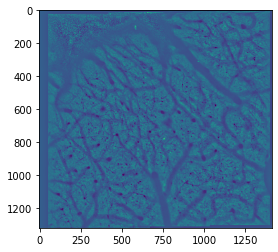

In [15]:
plt.imshow(lcned_stack[70])

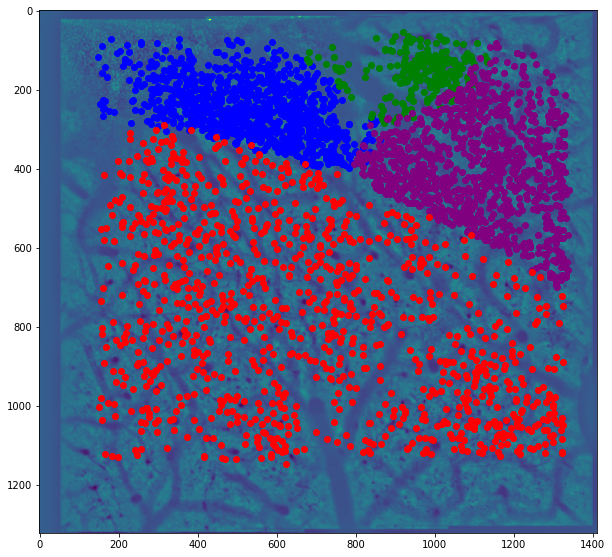

In [18]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(lcned_stack[70])
ax.scatter(*LM_cd[:,:2].T, c='blue')
ax.scatter(*AL_cd[:,:2].T, c='green')
ax.scatter(*RL_cd[:,:2].T, c='purple')
ax.scatter(*V1_cd[:,:2].T, c='red')

[1074.818  359.818  135.181]


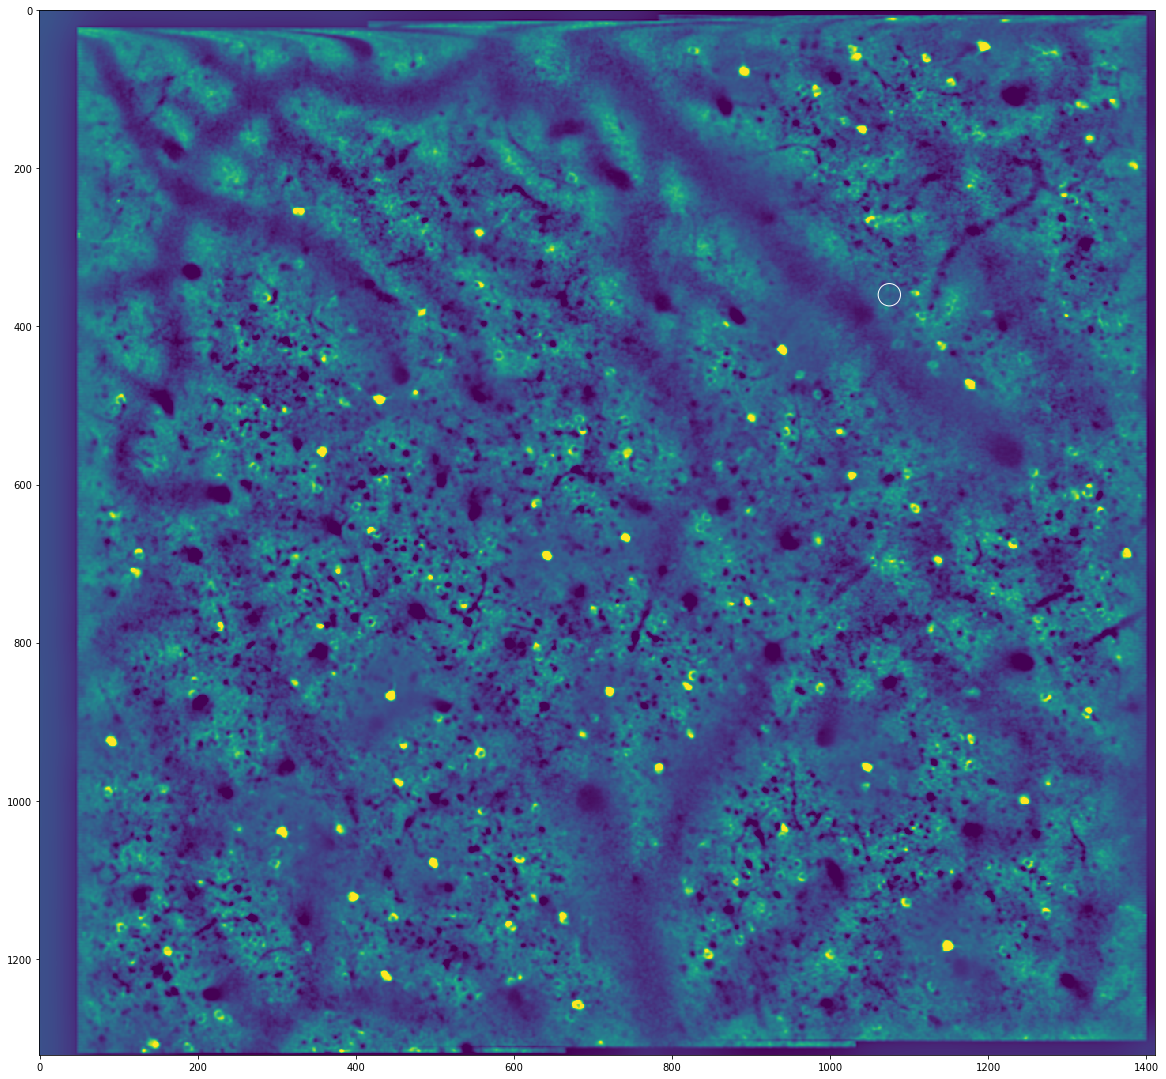

In [50]:
cell = RL_cd[0]
print(cell)
fig, ax = plt.subplots(figsize=(20,20))
ax.imshow(sharp_stack[int(cell[2])])
ax.scatter(*cell[:2], s=500, edgecolors='white', facecolors='none')

# Transform 2p stack coordinates to EM neuroglancer voxels

In [30]:
#only need to run once

from em2p_coreg import alignment
from em2p_coreg.alignment import solve_3d as s3
from em2p_coreg.alignment.transform import Transform, em_nm_to_voxels
import json
from em2p_coreg.links.make_ndviz_links import nglink1, example

# compute transformation
s2 = s3.Solve3D(input_data=s3.example2, args=[])
s2.run()

# load transformation
t = Transform(model='TPS')
with open(s2.args['output_json'], 'r') as f:
    t.from_dict(json.load(f))

average residual [dst units]: 1608.7174


In [238]:
test_point2p = np.array([[0.80435367, 0.38783457, 0.27464807]])

In [31]:
points2p = RL_cd[:10]/1000

In [55]:
RL_ng = get_munit_coords(RL_ld, stack_key, ref_frame='ng')

In [56]:
RL_ng

array([[2.68704e+05, 8.99540e+04, 1.35000e+02],
       [2.75714e+05, 8.86880e+04, 1.35000e+02],
       [2.86986e+05, 9.98150e+04, 1.35000e+02],
       ...,
       [3.10881e+05, 5.75420e+04, 4.12000e+02],
       [2.38942e+05, 9.25110e+04, 4.15000e+02],
       [3.28534e+05, 1.09956e+05, 1.40000e+02]])

In [72]:
points2p

array([[1.074818 , 0.359818 , 0.135181 ],
       [1.102857 , 0.354751 , 0.135128 ],
       [1.147942 , 0.399259 , 0.135326 ],
       [1.19901  , 0.384179 , 0.135198 ],
       [0.9060607, 0.42497  , 0.13569  ],
       [0.9794466, 0.447036 , 0.135741 ],
       [1.122183 , 0.421691 , 0.135472 ],
       [1.259386 , 0.426149 , 0.135368 ],
       [0.9028443, 0.469656 , 0.135935 ],
       [0.9105832, 0.462182 , 0.135887 ]])

In [121]:
out = []
for point in points2p[:,:2]:
    out.append(np.array([[0,-1],[1,0]]) @ point)
out = np.stack(out) + np.array([[1.412,0]])

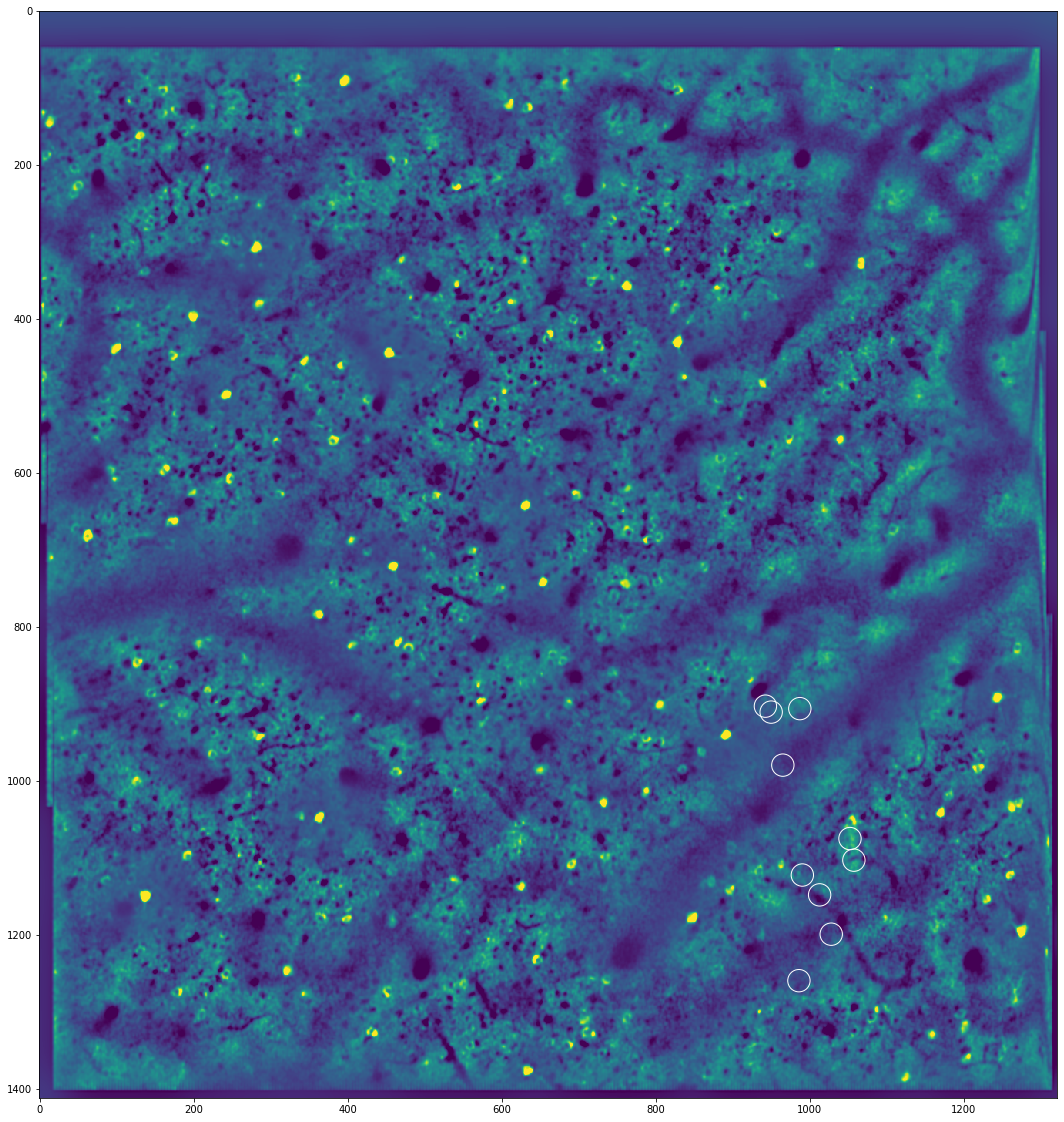

In [128]:
fig, ax = plt.subplots(figsize=(20,20))
ax.imshow(np.rot90(sharp_stack[135],k=-1))
ax.scatter(*out[:,:2].T*1000, s=500, edgecolors='white', facecolors='none')#, c=np.arange(len(points2p)), cmap=cm.bwr)

In [120]:
# transform 2p points to EM
EM_nm = t.transform(points2p)

# convert EM points to neuroglancer voxels
EM_vox = em_nm_to_voxels(EM_nm)
EM_vox

## generate neuroglancer link
# from em2p_coreg.links.make_ndviz_links import nglink1, example
# print(nglink1(example['template_url'], EM_vox[0]))

array([[300738, 131640,  21175],
       [302330, 131271,  21834],
       [293881, 129317,  22879],
       [300403, 124460,  24135],
       [285641, 139377,  17318],
       [281253, 137912,  18970],
       [284149, 133010,  22202],
       [290817, 122976,  25446],
       [274535, 140654,  17263],
       [276193, 140189,  17429]])

# Get functional fields

In [ ]:
# This come from pipeline.utils.registration
import numpy as np
import torch


def create_grid(um_sizes, desired_res=1):
    """ Create a grid corresponding to the sample position of each pixel/voxel in a FOV of
     um_sizes at resolution desired_res. The center of the FOV is (0, 0, 0).
    In our convention, samples are taken in the center of each pixel/voxel, i.e., a volume
    centered at zero of size 4 will have samples at -1.5, -0.5, 0.5 and 1.5; thus edges
    are NOT at -2 and 2 which is the assumption in some libraries.
    :param tuple um_sizes: Size in microns of the FOV, .e.g., (d1, d2, d3) for a stack.
    :param float or tuple desired_res: Desired resolution (um/px) for the grid.
    :return: A (d1 x d2 x ... x dn x n) array of coordinates. For a stack, the points at
    each grid position are (x, y, z) points; (x, y) for fields. Remember that in our stack
    coordinate system the first axis represents z, the second, y and the third, x so, e.g.,
    p[10, 20, 30, 0] represents the value in x at grid position 10, 20, 30.
    """
    # Make sure desired_res is a tuple with the same size as um_sizes
    if np.isscalar(desired_res):
        desired_res = (desired_res,) * len(um_sizes)

    # Create grid
    out_sizes = [int(round(um_s / res)) for um_s, res in zip(um_sizes, desired_res)]
    um_grids = [np.linspace(-(s - 1) * res / 2, (s - 1) * res / 2, s, dtype=np.float32)
                for s, res in zip(out_sizes, desired_res)] # *
    full_grid = np.stack(np.meshgrid(*um_grids, indexing='ij')[::-1], axis=-1)
    # * this preserves the desired resolution by slightly changing the size of the FOV to
    # out_sizes rather than um_sizes / desired_res.

    return full_grid


def resize(original, um_sizes, desired_res):
    """ Resize array originally of um_sizes size to have desired_res resolution.
    We preserve the center of original and resized arrays exactly in the middle. We also
    make sure resolution is exactly the desired resolution. Given these two constraints,
    we cannot hold FOV of original and resized arrays to be exactly the same.
    :param np.array original: Array to resize.
    :param tuple um_sizes: Size in microns of the array (one per axis).
    :param int or tuple desired_res: Desired resolution (um/px) for the output array.
    :return: Output array (np.float32) resampled to the desired resolution. Size in pixels
        is round(um_sizes / desired_res).
    """
    import torch.nn.functional as F

    # Create grid to sample in microns
    grid = create_grid(um_sizes, desired_res) # d x h x w x 3

    # Re-express as a torch grid [-1, 1]
    um_per_px = np.array([um / px for um, px in zip(um_sizes, original.shape)])
    torch_ones = np.array(um_sizes) / 2 - um_per_px / 2  # sample position of last pixel in original
    grid = grid / torch_ones[::-1].astype(np.float32)

    # Resample
    input_tensor = torch.from_numpy(original.reshape(1, 1, *original.shape).astype(
        np.float32))
    grid_tensor = torch.from_numpy(grid.reshape(1, *grid.shape))
    resized_tensor = F.grid_sample(input_tensor, grid_tensor, padding_mode='border')
    resized = resized_tensor.numpy().squeeze()

    return resized


def affine_product(X, A, b):
    """ Special case of affine transformation that receives coordinates X in 2-d (x, y)
    and affine matrix A and translation vector b in 3-d (x, y, z). Y = AX + b
    :param torch.Tensor X: A matrix of 2-d coordinates (d1 x d2 x 2).
    :param torch.Tensor A: The first two columns of the affine matrix (3 x 2).
    :param torch.Tensor b: A 3-d translation vector.
    :return: A (d1 x d2 x 3) torch.Tensor corresponding to the transformed coordinates.
    """
    return torch.einsum('ij,klj->kli', (A, X)) + b

# This functions are slightly modified from pipeline.stack
def get_grid(self, type='affine', desired_res=1):
    """ Get registered grid for this registration. 
    
    type: 'rigid', affine', 'nonrigid'
    desired_res: In um/px.
    """
    import torch

    # Get field
    field_key = self.proj(session='scan_session')
    field_dims = (reso.ScanInfo & field_key or meso.ScanInfo.Field &
                  field_key).fetch1('um_height', 'um_width')

    # Create grid at desired resolution
    grid = create_grid(field_dims, desired_res=desired_res)  # h x w x 2
    grid = torch.tensor(grid, dtype=torch.float32) # for torch v0.4.1: torch.as_tensor(grid, dtype=torch.float32) 

    # Apply required transform
    if type == 'rigid':
        params = (stack.Registration.Rigid & self).fetch1('reg_x', 'reg_y', 'reg_z')
        delta_x, delta_y, delta_z = params
        linear = torch.eye(3)[:, :2]
        translation = torch.tensor([delta_x, delta_y, delta_z])

        pred_grid = affine_product(grid, linear, translation)
    elif type == 'affine':
        params = (stack.Registration.Affine & self).fetch1('a11', 'a21', 'a31', 'a12',
                                                     'a22', 'a32', 'reg_x', 'reg_y',
                                                     'reg_z')
        a11, a21, a31, a12, a22, a32, delta_x, delta_y, delta_z = params
        linear = torch.tensor([[a11, a12], [a21, a22], [a31, a32]])
        translation = torch.tensor([delta_x, delta_y, delta_z])

        pred_grid = affine_product(grid, linear, translation)
    elif type == 'nonrigid':
        params = (stack.Registration.NonRigid & self).fetch1('a11', 'a21', 'a31', 'a12',
                                                       'a22', 'a32', 'reg_x', 'reg_y',
                                                       'reg_z', 'landmarks',
                                                       'deformations')
        rbf_radius = (stack.Registration.Params & self).fetch1('rbf_radius')
        a11, a21, a31, a12, a22, a32, delta_x, delta_y, delta_z, landmarks, deformations = params
        linear = torch.tensor([[a11, a12], [a21, a22], [a31, a32]])
        translation = torch.tensor([delta_x, delta_y, delta_z])
        landmarks = torch.from_numpy(landmarks)
        deformations = torch.from_numpy(deformations)

        affine_grid = affine_product(grid, linear, translation)
        grid_distances = torch.norm(grid.unsqueeze(-2) - landmarks, dim=-1)
        grid_scores = torch.exp(-(grid_distances * (1 / rbf_radius)) ** 2)
        warping_field = torch.einsum('whl,lt->wht', (grid_scores, deformations))

        pred_grid = affine_grid + warping_field
    else:
        raise PipelineException('Unrecognized registration.')

    return pred_grid.numpy()


def plot_grids(self, desired_res=5):
    """ Plot the grids for this different registrations as 3-d surfaces."""
    # Get grids at desired resoultion
    rig_grid = get_grid(self, 'rigid', desired_res)
    affine_grid = get_grid(self, 'affine', desired_res)
    nonrigid_grid = get_grid(self, 'nonrigid', desired_res)

    # Plot surfaces
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import axes3d, Axes3D

    fig = plt.figure(figsize=plt.figaspect(0.5) * 1.5)
    ax = fig.gca(projection='3d')
    ax.plot_surface(rig_grid[..., 0], rig_grid[..., 1], rig_grid[..., 2], alpha=0.5)
    ax.plot_surface(affine_grid[..., 0], affine_grid[..., 1], affine_grid[..., 2],
                    alpha=0.5)
    ax.plot_surface(nonrigid_grid[..., 0], nonrigid_grid[..., 1],
                    nonrigid_grid[..., 2], alpha=0.5)
#     ax.set_aspect('equal')
    ax.invert_zaxis()

    return fig

# Alignment image

## load the transformation

In [ ]:
from em2p_coreg.alignment.transform import Transform
import json
t = Transform(model='TPS')
with open(s2.args['output_json'], 'r') as f:
    t.from_dict(json.load(f))

## transform 2p points to EM

In [ ]:
EM_points = t.transform(mydata)

In [107]:
src_path = '/src/em2p_coreg/python/em2p_coreg'
data_path = src_path + '/data'

In [110]:
somata_landmarks = np.loadtxt(data_path + '/landmarks_somata_final.csv', usecols=(5,6,7), delimiter=',',dtype=float)
somata_landmarks_flipy = somata_landmarks.copy()
somata_landmarks_flipy.T[1] = 1.322 - somata_landmarks_flipy.T[1]

In [118]:
cell_coordinates = np.loadtxt(data_path + '/mydata.csv', delimiter=',')

In [419]:
vessels = lcned_stack[:, :, 70]

In [423]:
# source: plat.Scan & 'animal_id = 17797 and session=4 and scan_idx = 7'
im = plt.imread(data_path + '/AreaLabels_brighter.jpg')
im = im[60:700,180:840].copy()

Text(0.5, 0, 'x-axis (microns)')

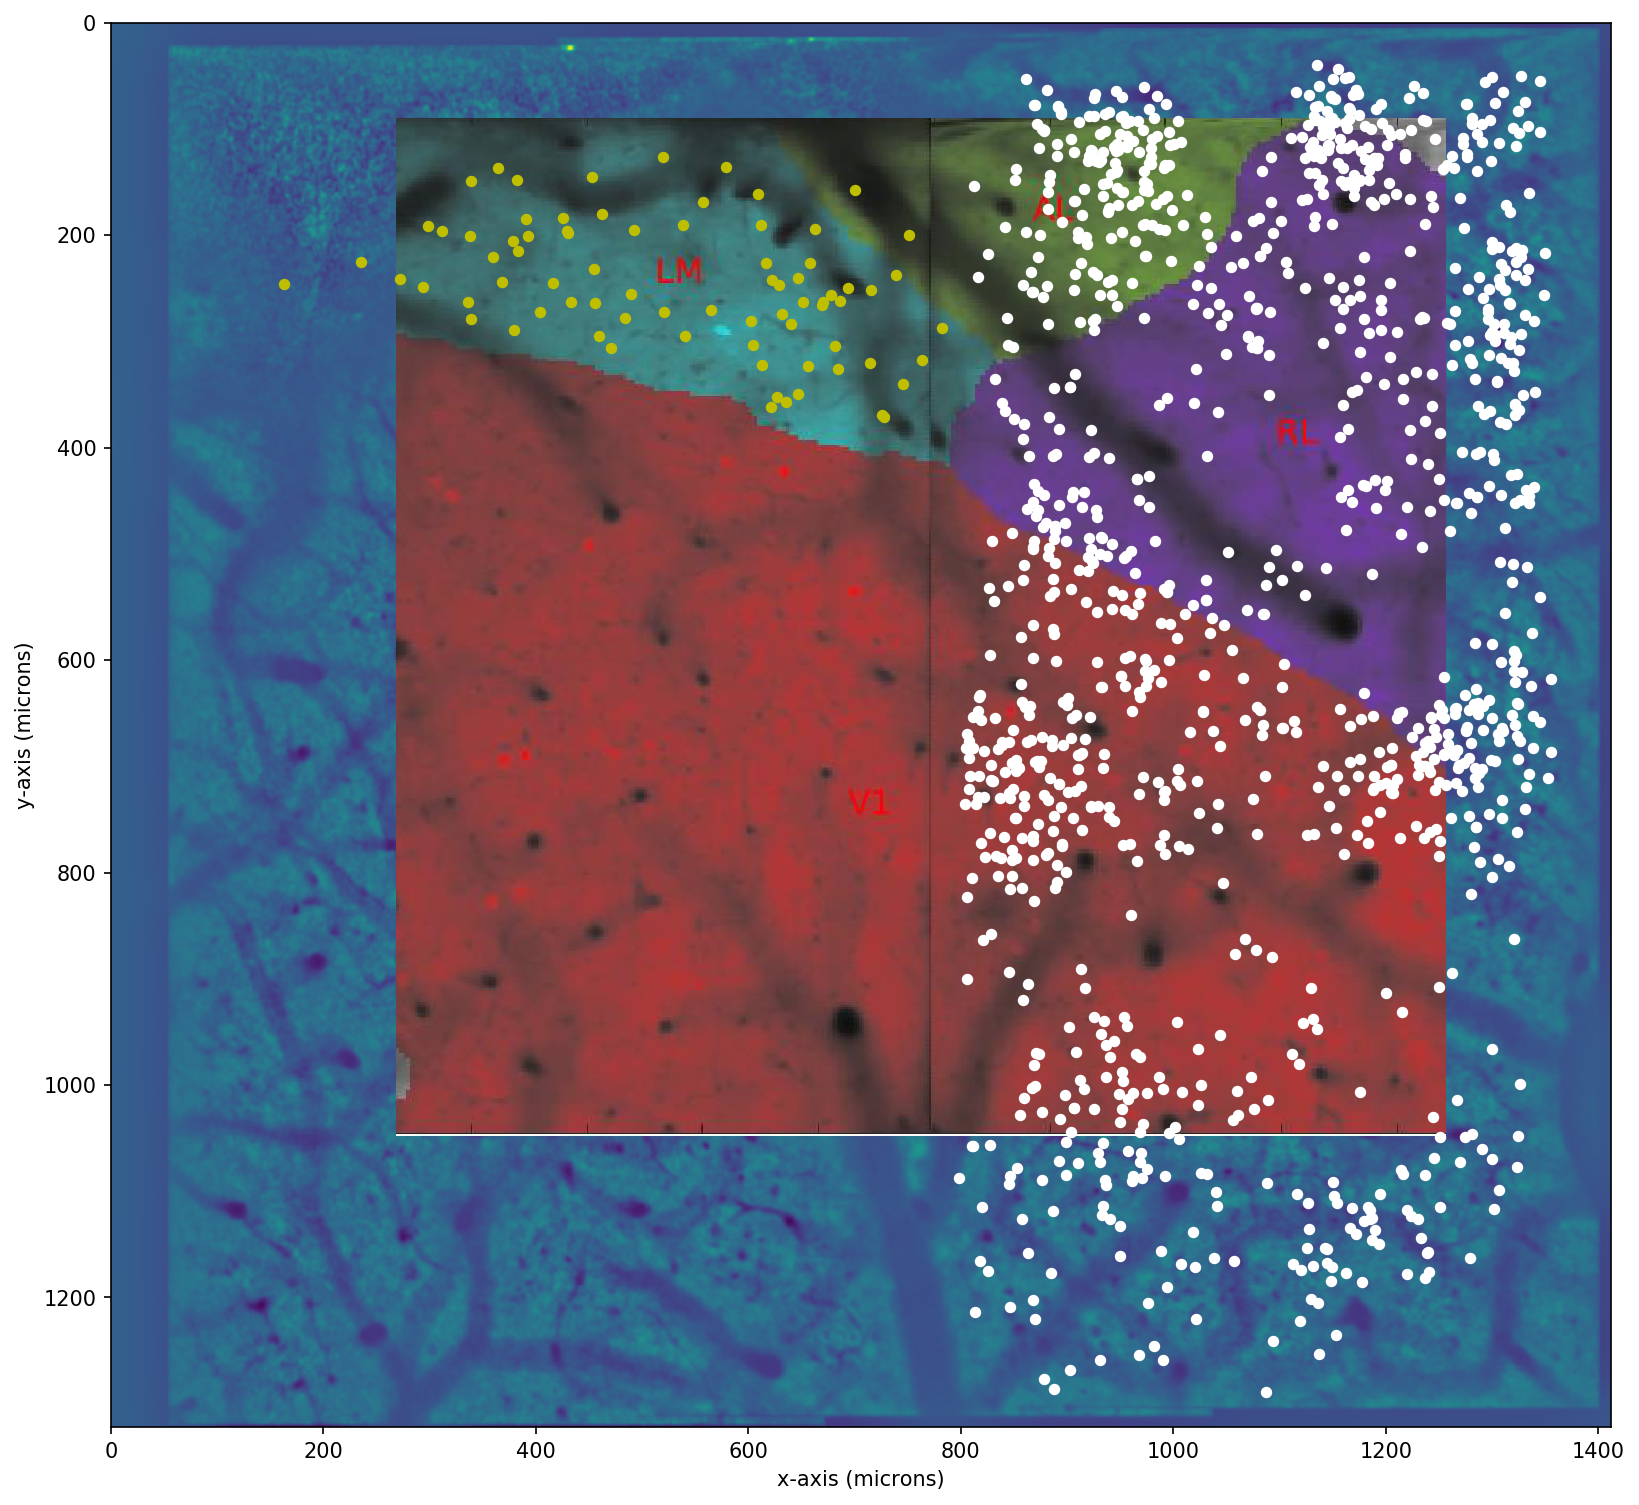

In [431]:
fig = plt.figure(figsize=(10,10), dpi=150)

ax = fig.add_axes((0,0,1,1),facecolor='w')
# ax.set_axis_off()
ax.imshow(vessels)
ax.set_aspect('equal')
ax.set_axis_off()

ax1 = fig.add_axes((0.19,0.19,0.7,0.75))
ax1.imshow(im,alpha=1)
# ax.set_xlim(0,1412)
# ax.set_ylim(1322,0)
ax1.set_aspect('equal')
ax1.set_axis_off()

ax2 = fig.add_axes((0,0,1,1),facecolor='none')
ax2.scatter(*somata_landmarks_flipy.T[:2]*1000, c='w', s=20)
ax2.scatter(*cell_coordinates.T[:2]*1000, c='y', s=20)

ax2.set_xlim(0,1412)
ax2.set_ylim(1322,0)
ax2.set_aspect('equal')
# ax2.set_axis_off()

ax2.set_ylabel('y-axis (microns)')
ax2.set_xlabel('x-axis (microns)')
# plt.savefig(src_path + '/outputs.png')







# Archive

In [136]:
p3.figure()
p3.scatter(*somata_landmarks_flipy.T)
p3.scatter(*cell_coordinates.T, color='blue')
# p3.quickvolshow(lcned_stack/1000)
p3.show()

In [207]:
mydata = np.loadtxt(data_path + '/mydata.csv', delimiter=',',dtype=float)

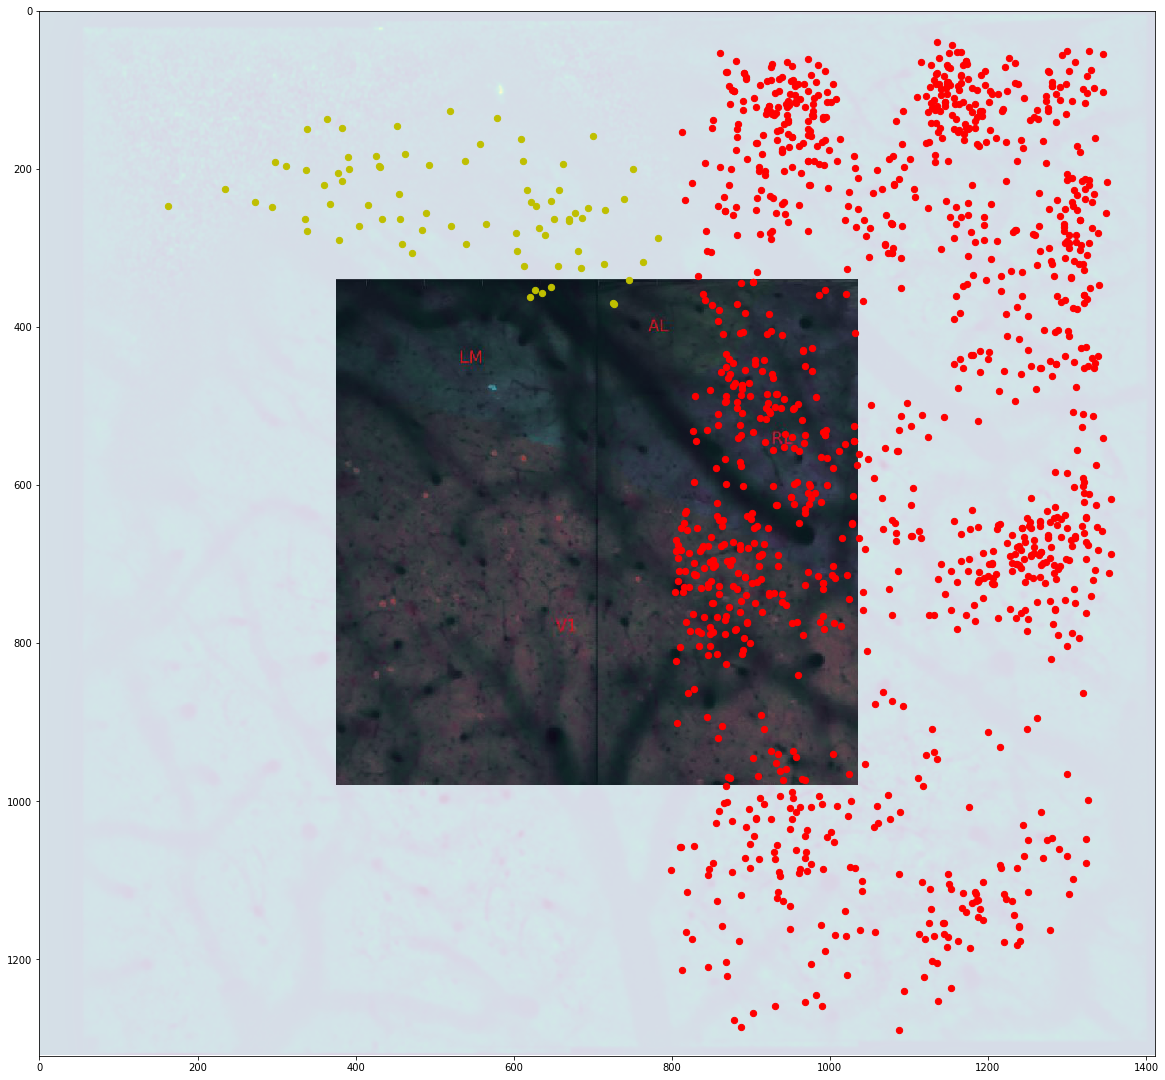

In [278]:
fig, ax = plt.subplots(1,1,figsize=(20,20))
ax.scatter(*somata_landmarks_flipy.T[:2]*1000, c='r', s=40)
ax.scatter(*cell_coordinates.T[:2]*1000, c='y', s=40)
ax.imshow(lcned_stack[60, :, :])
ax.imshow(constant, alpha=0.8)
ax.set_xlim(0,1412)
ax.set_ylim(1322,0)
ax.set_aspect('equal');

In [368]:
collection = dj.create_virtual_module('pipeline_collection','pipeline_collection')

In [362]:
anatomy = dj.create_virtual_module('pipeline_anatomy','pipeline_anatomy')


In [370]:
collection.CuratedScan()

*study_name    *animal_id    *session    *scan_idx    *scan_purpose  *score_ts      username     score     notes         
+------------+ +-----------+ +---------+ +----------+ +------------+ +------------+ +----------+ +-------+ +------------+
lateral_param  21553         8           13           param_char     2019-05-28 13: taliah       5         None          
lateral_param  21553         8           14           param_char     2019-05-28 13: taliah       5         None          
lateral_param  21553         9           6            param_char     2019-05-30 16: taliah       4         None          
lateral_param  21553         9           11           param_char     2019-05-30 16: taliah       4         None          
lateral_param  21553         10          8            param_char     2019-05-28 13: taliah       5         None          
lateral_param  21553         12          9            param_char     2019-05-30 16: taliah       5         None          
lateral_param  21553         13          6            param_char     2019-05-30 16: taliah       5         None          
lateral_param  21553         13          9            param_char     2019-05-30 16: taliah       3         bubble over lm
lateral_param  21553         14          5            param_char     2019-05-30 16: taliah       5         None          
mei            22083         7           8            mei_gen        2019-07-15 17: taliah       5         V1            
widefield_para 20892         1           2            widefield_reti 2019-04-27 23: taliah       5         None          
widefield_para 20892         7           6            ROI_retinotopy 2019-04-27 23: taliah       5         pref          
   ...
 (Total: 161)

In [365]:
anatomy.AreaMask & 'animal_id = 17797 and session = 3'

*animal_id    *session    *scan_idx    *brain_area    *field    ret_idx     mask      
+-----------+ +---------+ +----------+ +------------+ +-------+ +---------+ +--------+
17797         3           4            AL             1         2           =BLOB=    
17797         3           4            LM             1         2           =BLOB=    
17797         3           4            RL             1         2           =BLOB=    
17797         3           4            V1             1         2           =BLOB=    
17797         3           18           AL             1         1           =BLOB=    
17797         3           18           LM             1         1           =BLOB=    
17797         3           18           RL             1         1           =BLOB=    
17797         3           18           V1             1         1           =BLOB=    
 (Total: 8)

In [212]:
ret_key = 'animal_id=17797'

In [213]:
plat = dj.create_virtual_module('pipeline_platinum','pipeline_platinum')
plat.CuratedScan & ret_key & 'scan_purpose LIKE "%%retinotopy%%"'

*animal_id    *session    *scan_idx    *scan_purpose  username     score     notes         
+-----------+ +---------+ +----------+ +------------+ +----------+ +-------+ +------------+
17797         1           2            widefield_reti Paul         2         2P1, horizonta
17797         1           7            widefield_reti Paul         2         2P1, vertical,
17797         3           4            widefield_reti Paul         4         2P4           
17797         3           6            widefield_reti Paul         4         2P4           
17797         3           17           ROI_retinotopy Paul         4         2P4           
17797         3           18           ROI_retinotopy Paul         4         2P4           
 (Total: 6)